# Computer Vision pt 2
Convolutions, Filters and Clustering

In [1]:
## pip install numpy
import numpy as np

## pip install matplotlib
import matplotlib.image as mpimg  # mpimg.imread(path)
import matplotlib.pyplot as plt  # plt.imshow(np.array)

## pip install scipy scikit-image
from scipy.ndimage import generic_filter, convolve

## pip install opencv-python

import cv2  # cv2.kmeans and prebuilt computer vision functions ie grayscale

# Scikit-Image
https://docs.scipy.org/doc/scipy/reference/ndimage.html

Book: Elegant Scipy

# Convolutions w/ Scipy
https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.filters.convolve.html

"Convolution is the process of adding each element of the image to its local neighbors, weighted by the kernel."(https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution)

Applications include blurring, sharpening, detecting edges & shapes or generic feature recognizers.

Cat image value range, [0.0, 1.0]


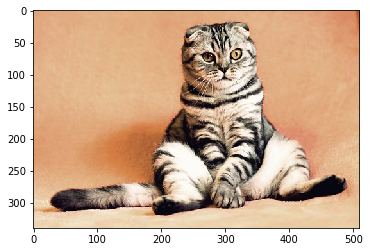

In [2]:
## Convolution Example
cat = mpimg.imread('../input/cat-images/cat3.jpg')

# for the convolutions to work, the image should be normalized 
# to [0, 1] as opposed to the standard [0, 255]!
# this is for math reasons
cat = cat / 255
print(f"Cat image value range, [{np.min(cat)}, {np.max(cat)}]")

plt.imshow(cat)
plt.show()

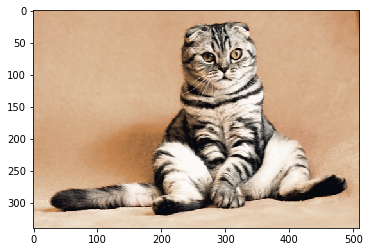

In [3]:
## Blurred
# This kernel is for a 3 channel image.
blur_kernel = [[
    [.1, .4, .1], 
    [.4, .8, .4], 
    [.1, .4, .1]]]

blur_kernel = np.array(blur_kernel)
blur_kernel /= np.sum(blur_kernel)  # ensure kernel sums to ~1

blur_kernel_sum = np.sum(blur_kernel)
assert blur_kernel_sum <= 1.01 and blur_kernel_sum >= .99, f"This is bad math yo, {blur_kernel_sum}"

blurred = convolve(cat, blur_kernel)
plt.imshow(blurred)
plt.show()

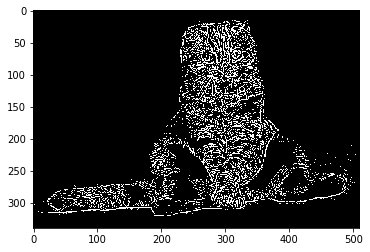

In [4]:
## Basic edge detection
# This kernel is for a 1 channel image, but you can still find the 
# edges w/ a 3 channel image w/ less information loss
edge_kernel = [
    [-1, -1, -1], 
    [-1, 8, -1], 
    [-1, -1, -1]]

edge_kernel = np.array(edge_kernel)

grayscale_cat = np.mean(cat, axis=2)

edges = convolve(grayscale_cat, edge_kernel)
binarized_edges = np.where(edges > .25, 1, 0)

plt.imshow(binarized_edges, cmap='gray')
plt.show()

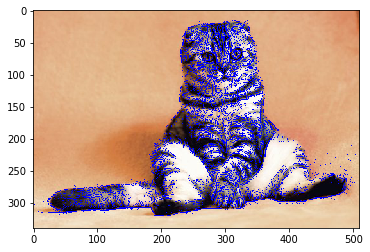

In [5]:
## Appling edge information to original image
test_cat = np.copy(cat)
test_cat[np.where(binarized_edges)] = np.array([0., 0., 1.])

plt.imshow(test_cat)
plt.show()

# you can probably do something useful with this
# large kernel blur w/ .5 threshold on binarized == object detection?

# Generic Filter / Kernel w/ Scipy
https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generic_filter.html#scipy.ndimage.generic_filter

Generic filters are like convolutions but instead of the output specifically being the dot product of the data in the sliding matrix and the kernel, the output is dictated by an arbitrary function on the sliding window.

This allows the creation of arbitrary filters to act on any type of signal.

Wolfram 1D, Rule: 184


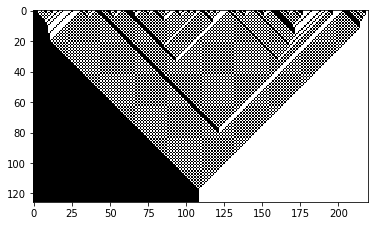

Wolfram 1D, Rule: 90


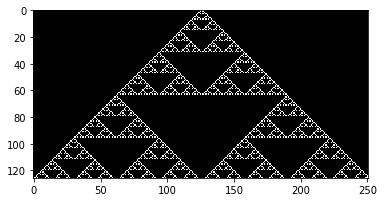

Wolfram 1D, Rule: 30


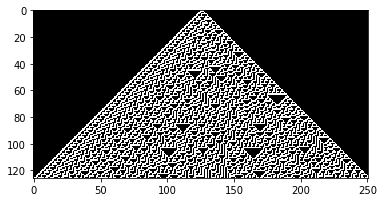

Wolfram 1D, Rule: 135


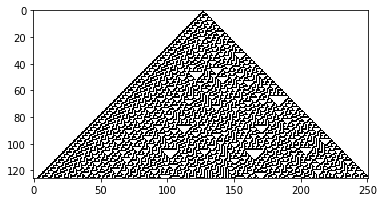

2

In [6]:
## Generic Filters
# https://github.com/coledie/1D-Automaton/blob/master/wolfram_automaton.py
# Here I am using generic filters to generate the next iteration of a
# cellular automaton rule. Line 0 in the image is iteration 0.

def wolfram_1d(rule, init_state=None, iterations=125, show=True):
    """
    Generates 1D Wolfram automaton states over a number iterations.
    Parameters
    ----------
    rule: int [0, 255]
        Number associated with the next state rule.
    init_state: ndarray[0./1.], any size, default=[0, ... 1, ... 0]
        State to start simualation with.
    iterations: int, default=500
        Number of new states to solve for.
    show: bool, default=True
        Use opencv to display states or not.
    Returns
    -------
    ndarray[iterations+1, len(init_state] All calculated states, stacked.
    """
    def rule_map(rule):
        """
        Generate the map for the cell and its neighbors to the new cell state based
        on the given rule number.
        Parameters
        ----------
        rule: int
            Number associated with the next state rule.
        Returns
        -------
        dict, {'': 1/0 for all permutations of cell and neighbors.}
        """
        STATES = ['1', '0']
        reverse_binary = [x + y + z for x in STATES for y in STATES for z in STATES]

        rule_binary = []
        for i in range(7, -1, -1):
            rule_binary += [int(rule / 2**i >= 1)]
            rule %= 2**i

        return dict(zip(reverse_binary, rule_binary))

    state = np.zeros(shape=251); state[state.size // 2 + 1] = 1
    if init_state is not None:
        state = init_state

    image = state.copy()

    state_map = rule_map(rule)

    RULE = lambda neighbors: state_map["".join([str(int(v)) for v in neighbors])]

    footprint = np.ones(shape=(3))

    for _ in range(iterations):
        state = generic_filter(state, RULE, footprint=footprint)

        image = np.vstack((image, state))

    if show:
        print(f"Wolfram 1D, Rule: {rule}")
        plt.imshow(image, cmap='gray')
        plt.show()

    return image

wolfram_1d(184, init_state=np.where(np.random.uniform(0, 1, size=220) > .5, 1., 0.))
wolfram_1d(90)  ## Serpinski Triangle
wolfram_1d(30)  ## Chaos
wolfram_1d(135)  ## Inverse of 30

1 + 1

# K Means Clustering
https://en.wikipedia.org/wiki/K-means_clustering

https://docs.opencv.org/2.4/modules/core/doc/clustering.html

K Means Clustering is an unsupervised clustering algorithms, it attempts to classify points based on their proximity in state space without the need to tell the model anything but how many classes to look for, just give it a dataset and it will solve. In an image, the state space for pixels is an axis for each color and two more axes for the X and Y axis(?) thus, each pixel in the image has a different location in this state space.

K Means is a clustering algorithm that attempts to split points in the dataset into K distinct groups. This is useful for image segmentation. K Means can be used to segment an image based on color.

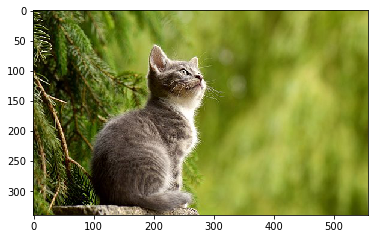

In [7]:
## K Means Clustering￼
# https://docs.opencv.org/2.4/modules/core/doc/clustering.html
image = mpimg.imread('../input/cat-images/cat.jpg')
plt.imshow(image)
plt.show()

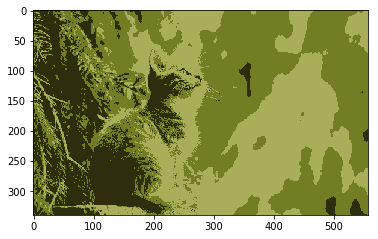

In [8]:
## K Means Clustering Color Data
# List of arbitrary data values, in this case (R, G, B) 
# - any data can be added that the algorithm will be able to use
vectorized = image.reshape((-1, 3))
vectorized = np.float32(vectorized)

# Constants for cv2.kmeans
termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 3
_, label, center = cv2.kmeans(vectorized, K, bestLabels=None, criteria=termination_criteria, attempts=10, flags=0)
# label is the group number for every vector in vectorized
# center is the centroid poisition of every group

# Color code pixels based on their class and the centroid color of their class
result_image = np.uint8(center)[label.flatten()]
result_image = result_image.reshape((image.shape))

plt.imshow(result_image)
plt.show()

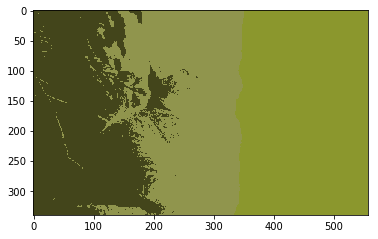

Vectorized Data, (R, G, B, X, Y)
[[ 26  45   0   0   0]
 [ 46  62  13   0   1]
 [ 39  52   8   0   2]
 ...
 [ 82  90   4 339 554]
 [ 83  93   6 339 555]
 [ 83  93   6 339 556]]


In [9]:
## K Means Clustering Color and Location Data
## In this example, we also pass location data to cv2.kmeans
# (R, G, B, X, Y)
vectorized = image.reshape((-1, 3))

# add x, y data to vectorized
idxs = np.array([idx for idx, _ in np.ndenumerate(np.mean(image, axis=2))])
vectorized = np.hstack((vectorized, idxs))

termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 3
_, label, center = cv2.kmeans(np.float32(vectorized), K, bestLabels=None, criteria=termination_criteria, attempts=10, flags=0)

center = np.uint8(center)[:, :3]

result_image = center[label.flatten()]
result_image = result_image.reshape((image.shape))

plt.imshow(result_image)
plt.show()

print("Vectorized Data, (R, G, B, X, Y)")
print(vectorized)

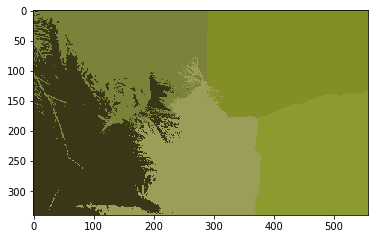

In [10]:
## By changing K, we can change the number of groups

# (R, G, B, X, Y)
vectorized = image.reshape((-1, 3))
idxs = np.array([idx for idx, _ in np.ndenumerate(np.mean(image, axis=2))])
vectorized = np.hstack((vectorized, idxs))

termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Now there are 5 groups
K = 5
_, label, center = cv2.kmeans(np.float32(vectorized), K, bestLabels=None, criteria=termination_criteria, attempts=10, flags=0)

center = np.uint8(center)[:, :3]

result_image = center[label.flatten()]
result_image = result_image.reshape((image.shape))

plt.imshow(result_image)
plt.show()

Scipy has many other clustering algorithms. Some are complicated and meant to be used on data sets rather than images.

https://scikit-learn.org/stable/modules/clustering.html

By applying convolutions, filters, and clustering, we are able to isolate useful data.